In [26]:
import sys
sys.path.append('../')
import torch
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM,BioSRMicrotubules,BioSRFActin
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
from torch.nn.functional import interpolate
import numpy as np
from pytorch_lightning import seed_everything
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from fit.utils.utils import denormalize

trained_model_path= '/home/aman.kukde/Projects/FourierImageTransformer/models/MNIST/fast/sum/Fast_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_26-05_21-37-24/'
checkpoints = os.listdir(trained_model_path)
checkpoints.remove('last.ckpt')
checkpoints.remove('wandb')
trained_model_path = trained_model_path + checkpoints[3]
print(trained_model_path)
dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]
# dataset = "MNIST"
# model_type = 'mamba'
# loss = 'sum'

seed_everything(22122020)

if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=256, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)
if dataset == "Bio":
    dm = BioSRFActin('./', 8)
# dm = BioSRMicrotubules('./', 8)
dm.prepare_data()
dm.setup()
r, phi, flatten_order, order, fc_per_ring = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              w_phi = 1000,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 6,
                              model_type = model_type,
                              fc_per_ring=fc_per_ring).cuda()

print("model initialized")

if 1:
    weights = torch.load(trained_model_path)['state_dict']
    model.load_state_dict(weights, strict=True)
    model.cuda()
    model.eval()
    print('Trained Model Loaded Successfully !!!')
else:
    print('Model not loaded, Randomly initialized')

Seed set to 22122020


/home/aman.kukde/Projects/FourierImageTransformer/models/MNIST/fast/sum/Fast_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_26-05_21-37-24/epoch=848-step=365070.ckpt
Using Full MNIST dataset
model initialized
Trained Model Loaded Successfully !!!


In [33]:

lowres_total = []
pred_total = []
gt_total = []
i = 0
for fc, (mag_min, mag_max) in tqdm(dm.test_dataloader()):
    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    fc = fc[:, model.dst_flatten_order]
    x_input = fc.clone()


    with torch.no_grad():
        pred = model.sres.forward_i(x_input)
        fc_loss, amp_loss, phi_loss,weighted_phi_loss = model.criterion(pred, fc, mag_min, mag_max)
        # print(f'fc_loss: {fc_loss}, amp_loss: {amp_loss}, phi_loss: {phi_loss}, weighted_phi_loss: {weighted_phi_loss}')
    
    lowres = x_input.clone()
    lowres[:, model.input_seq_length:] = 0.
    # lowres = torch.zeros_like(pred)
    # lowres[:, :model.input_seq_length] = fc[:, :model.input_seq_length]
    
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc, mag_min=mag_min, mag_max=mag_max)

    lowres_img_denormed = denormalize(lowres_img,
                                          dm.mean,
                                          dm.std)
    pred_img_denormed = denormalize(pred_img, dm.mean,
                                    dm.std)
    gt_img_denormed = denormalize(gt_img, dm.mean,
                                    dm.std)

    lowres_psnr = PSNR(gt_img_denormed, lowres_img_denormed)
    pred_psnr = PSNR(gt_img_denormed, pred_img_denormed)
    gt_psnr = PSNR(gt_img_denormed, gt_img_denormed)

    lowres_total.append(lowres_psnr)
    pred_total.append(pred_psnr)
    gt_total.append(gt_psnr)


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [01:11<00:00,  1.78s/it]


In [34]:
lowres_all == a

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

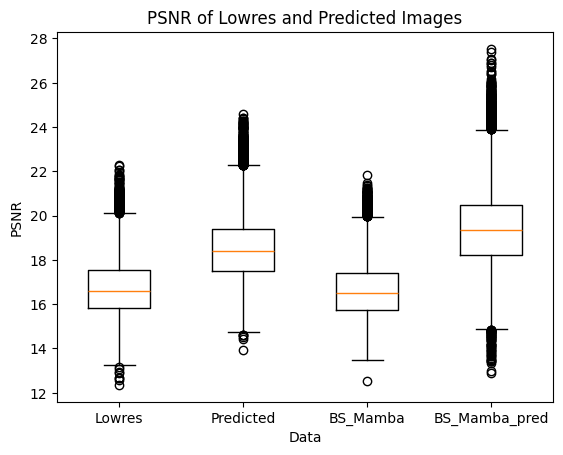

In [30]:

lowres_all = torch.cat(lowres_total)
pred_all = torch.cat(pred_total)
diff_all = pred_all - lowres_all
gt_all = torch.cat(gt_total)

a = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_lowres.pt')
b = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_pred.pt')

fig, ax = plt.subplots()
ax.boxplot([lowres_all.cpu().numpy(),pred_all.cpu().numpy(),a.cpu().numpy(), b.cpu().numpy()], widths= 0.5, labels = ['Lowres','Predicted','BS_Mamba', 'BS_Mamba_pred']);
ax.set_xlabel("Data")
ax.set_ylabel("PSNR")
ax.title.set_text(f"PSNR of Lowres and Predicted Images")

In [29]:
a = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_lowres.pt')
b = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/inference_results/inference_results_mamba/mamba_pred.pt')

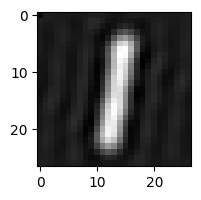

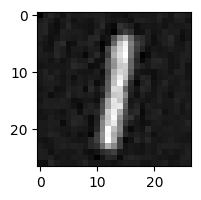

In [18]:
plt.figure(figsize = (2,2))
plt.imshow(lowres_img.cpu().numpy()[0], cmap = 'gray')
plt.show()
plt.figure(figsize = (2,2))
plt.imshow(pred_img.cpu().numpy()[0], cmap = 'gray')
plt.show()

fc_loss: 813.2421875, amp_loss: 27.63933563232422, phi_loss: 0.785602867603302, weighted_phi_loss: 785.6028442382812


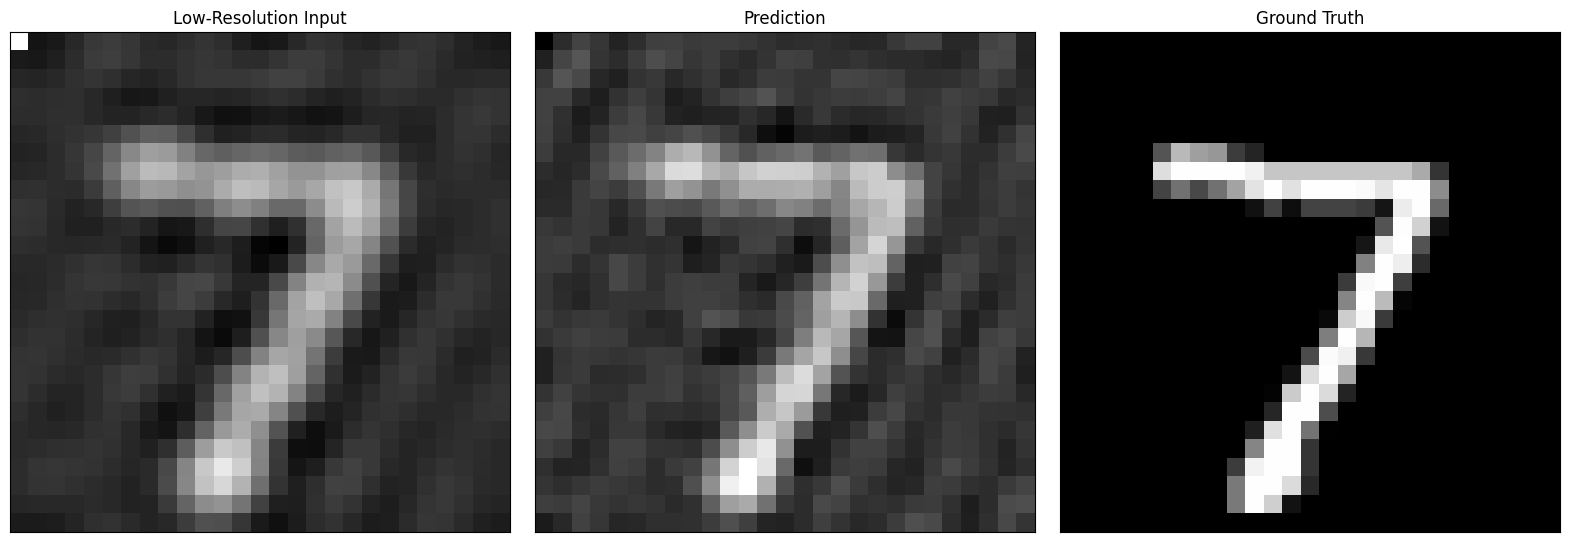

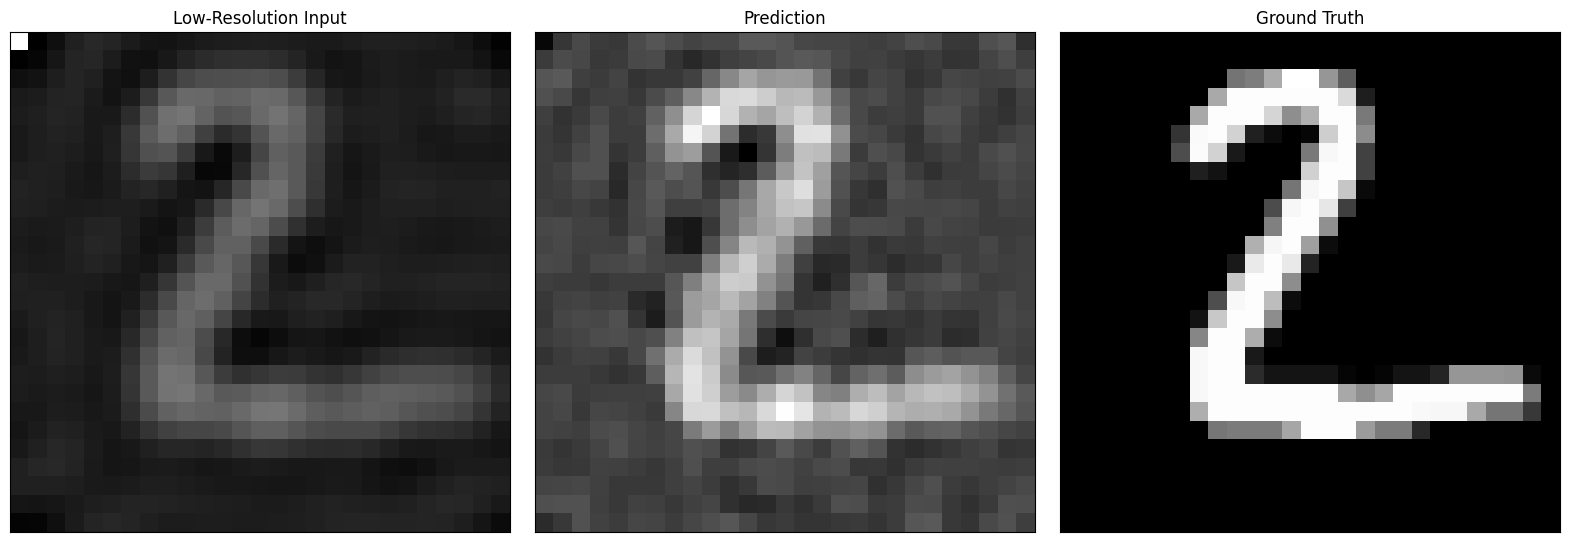

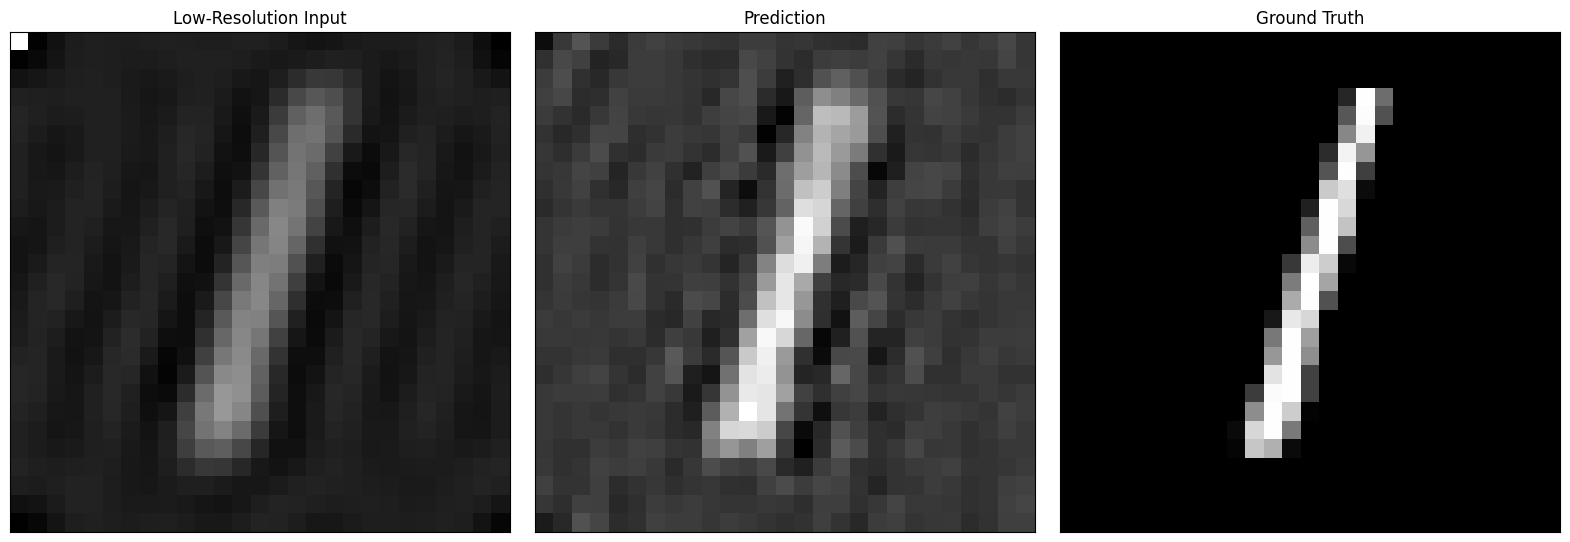

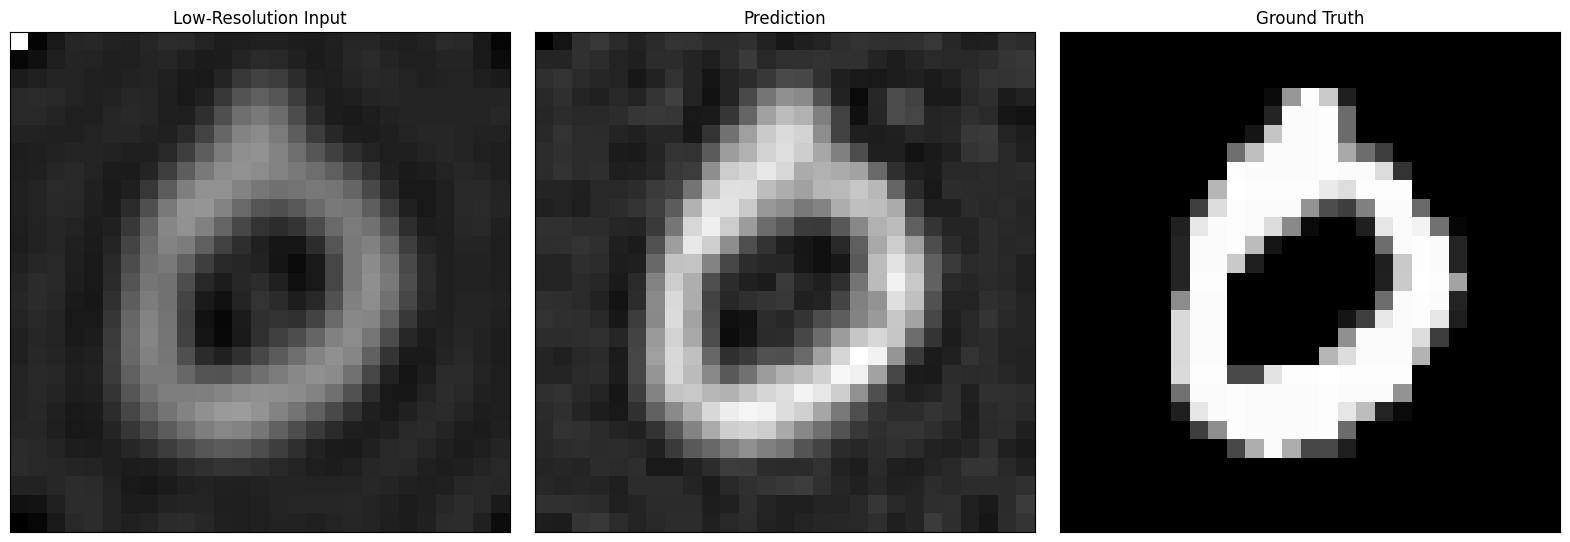

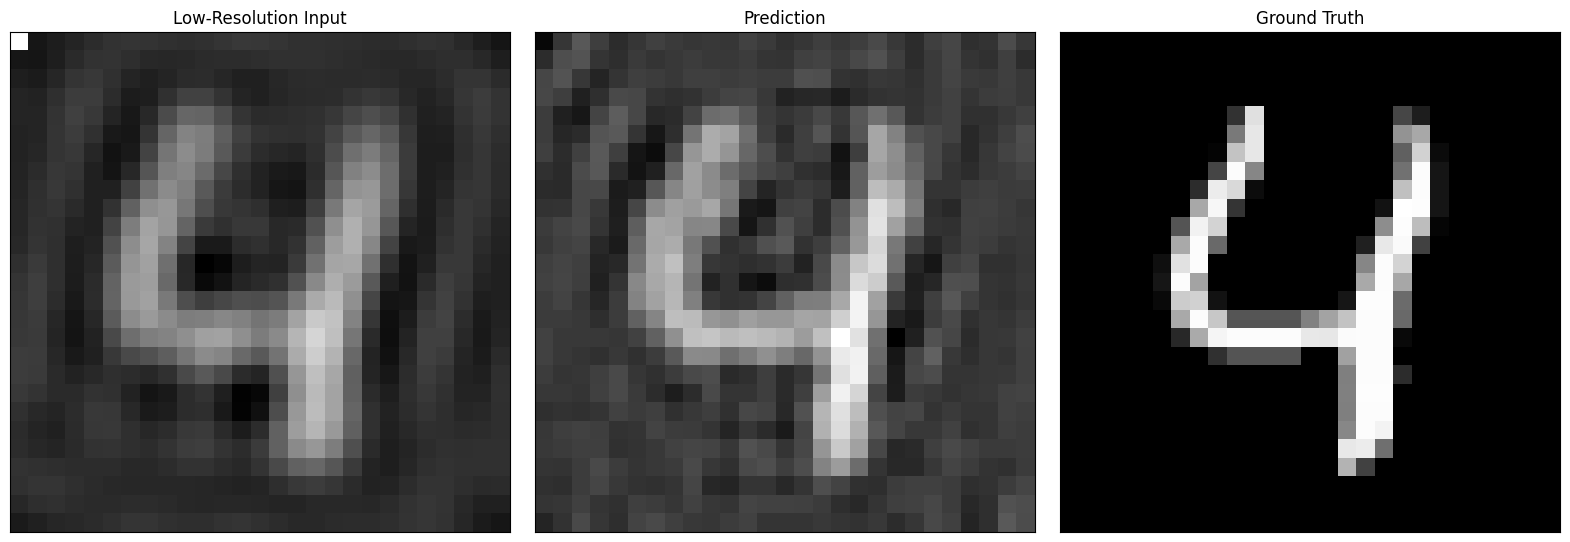

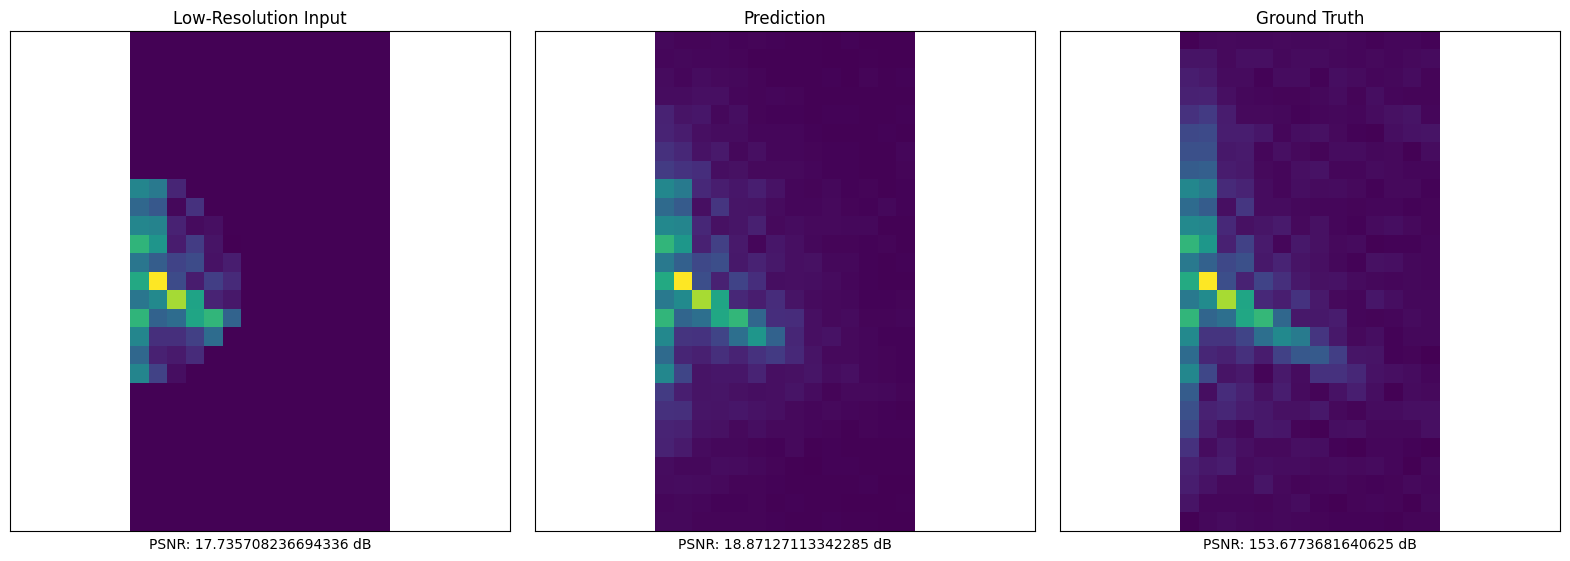

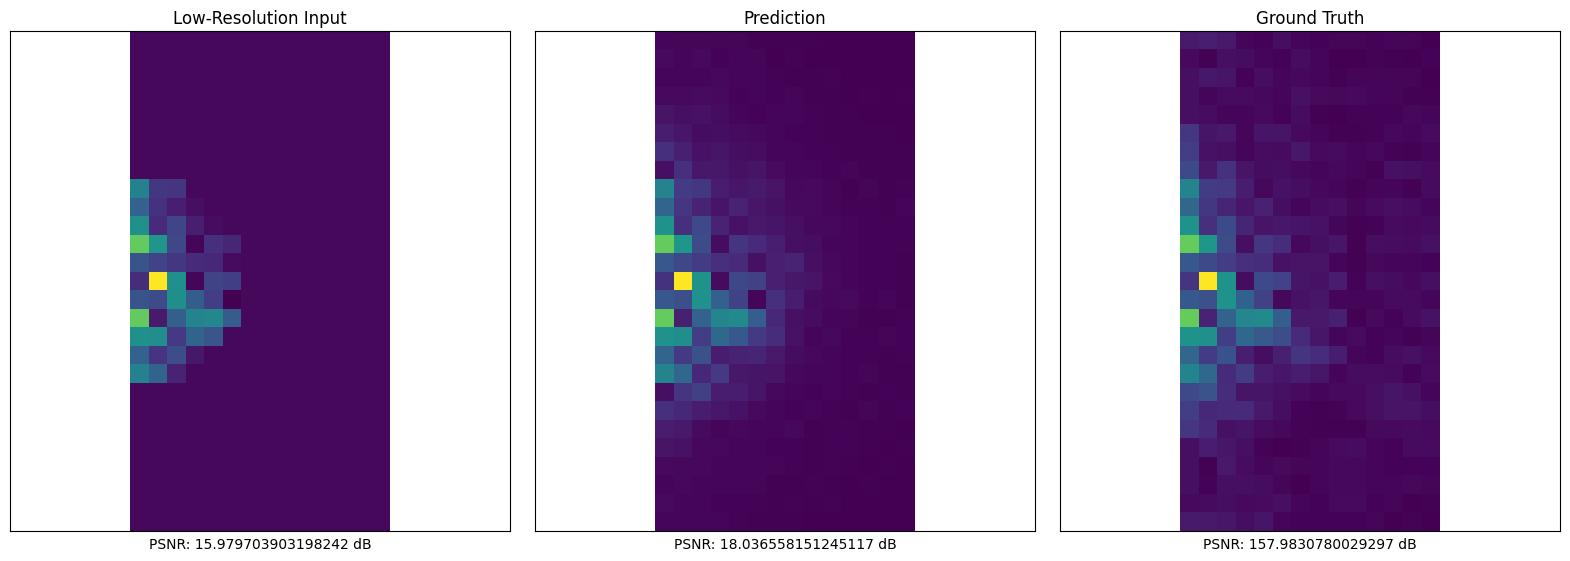

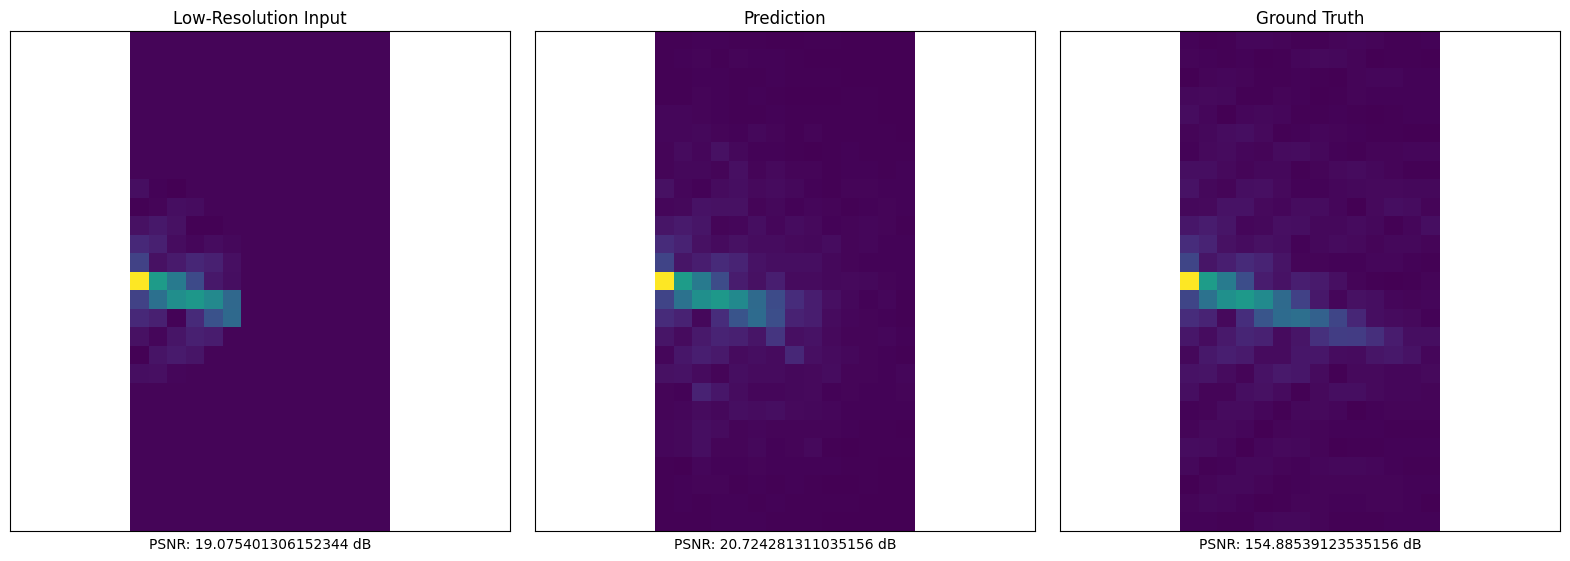

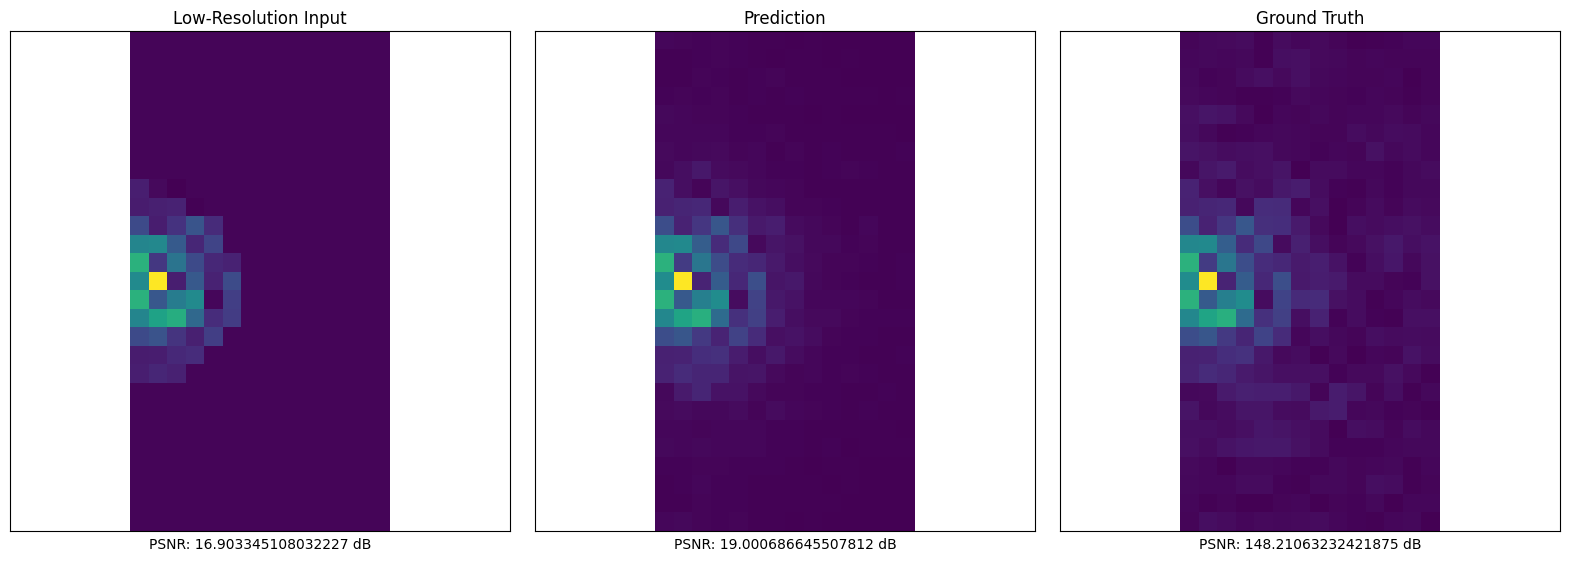

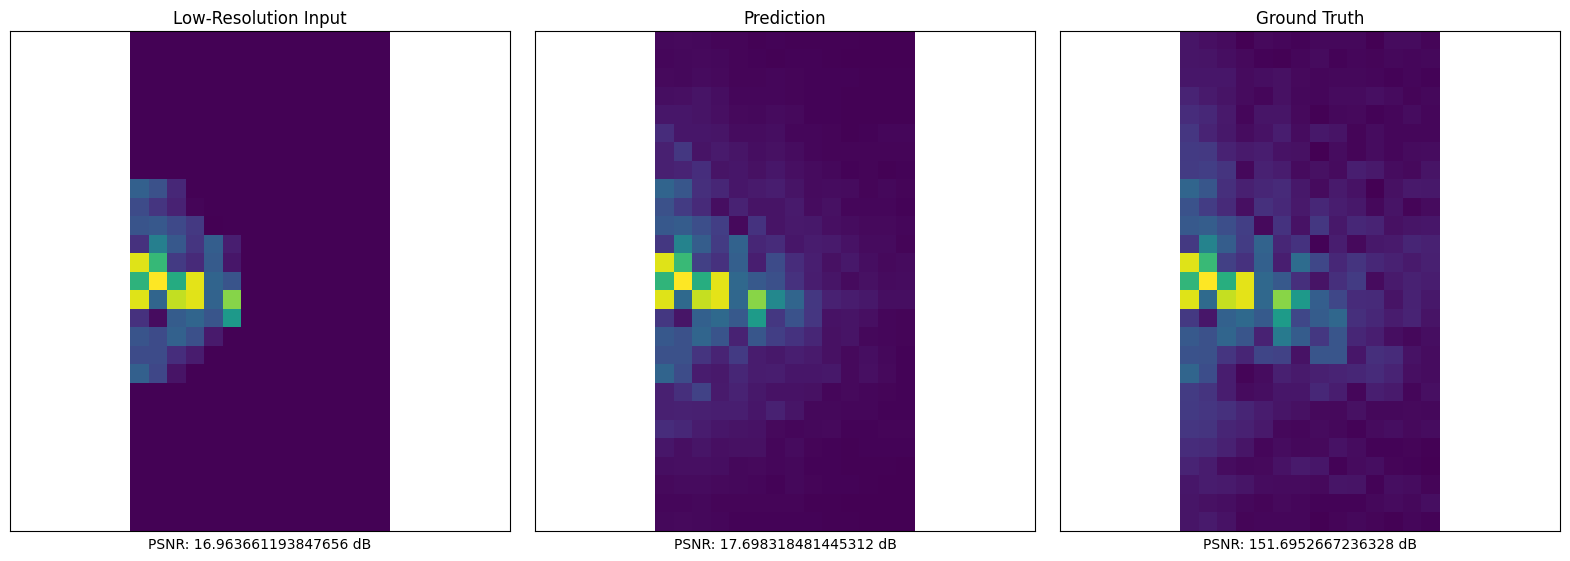

In [19]:
def predict_one_test_batch(no_of_images = 5, fwd = True):
    i = 0
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
        i+=1
        if i ==12:
            break

    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    fc = fc[:, model.dst_flatten_order]
    x_input = fc.clone()


    with torch.no_grad():
        if fwd:
            # pred = model.sres.forward(x_input)
            pass
        else:
            pred = model.sres.forward_i(x_input)
        fc_loss, amp_loss, phi_loss,weighted_phi_loss = model.criterion(pred, fc, mag_min, mag_max)
        print(f'fc_loss: {fc_loss}, amp_loss: {amp_loss}, phi_loss: {phi_loss}, weighted_phi_loss: {weighted_phi_loss}')
    fig = plt.figure()
    lowres = x_input.clone()
    lowres[:, model.input_seq_length:] = 0
    # lowres[:] = 0
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc, mag_min=mag_min, mag_max=mag_max)


    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)

    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
    # fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(no_of_images):
        fig2 = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');


    for i in range(no_of_images):
        sample = i
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');

predict_one_test_batch(5, fwd=False)
# predict_one_test_batch(5, fwd=True)